makemore_part5 we started applying wavenet with MLPs to our names generator. However the original paper used dilated convolutions. So here we'll:
* Understand what are convolutions
* Implement a regular convolution layer
* Apply it to our names generator

In [25]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import einops
import math

g = torch.Generator().manual_seed(2147483647)

In [26]:
names = list((open('data/names/names.txt', 'r').read().splitlines()))

chars = sorted(set(''.join(names)))
char_to_idx = {s: i for i, s in enumerate(['.'] + chars)}
index_to_char = {i: s for s, i in char_to_idx.items()}

names[:5], chars[:5]

(['emma', 'olivia', 'ava', 'isabella', 'sophia'], ['a', 'b', 'c', 'd', 'e'])

In [27]:
xs, ys = [], []
context_size = 8
for name in names:
    context = [0] * context_size
    for char in name + ".":
        idx = char_to_idx[char]
        xs.append(context)
        ys.append(idx)
        context = context[1:] + [idx]

xs, ys = torch.tensor(xs), torch.tensor(ys)
xs.shape, ys.shape

(torch.Size([228146, 8]), torch.Size([228146]))

In [28]:
train_size = int(0.8 * len(xs))
dev_size = int(0.1 * len(xs))
test_size = len(xs) - train_size - dev_size
train_size, dev_size, test_size, train_size + dev_size + test_size

idxs_in_random_order = torch.randperm(len(xs))
train_idxs = idxs_in_random_order[:train_size]
dev_idxs = idxs_in_random_order[train_size:train_size + dev_size]
test_idxs = idxs_in_random_order[train_size + dev_size:]

train_xs, train_ys = xs[train_idxs], ys[train_idxs]
dev_xs, dev_ys = xs[dev_idxs], ys[dev_idxs]
test_xs, test_ys = xs[test_idxs], ys[test_idxs]

train_xs.shape, train_ys.shape, dev_xs.shape, dev_ys.shape, test_xs.shape, test_ys.shape

(torch.Size([182516, 8]),
 torch.Size([182516]),
 torch.Size([22814, 8]),
 torch.Size([22814]),
 torch.Size([22816, 8]),
 torch.Size([22816]))

In [29]:
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.W = torch.randn((in_features, out_features), generator=g) / in_features**0.5
        self.b = torch.zeros(out_features) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])


In [30]:
class BatchNorm1d:
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        self.eps = eps
        self.momentum = momentum
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)
        self.training = True
    
    def __call__(self, x):
        dim = 0 if x.ndim == 2 else (0, 1)
        batch_mean = x.mean(dim=dim, keepdim=True) if self.training else self.running_mean
        batch_var = x.var(dim=dim, keepdim=True) if self.training else self.running_var
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean.squeeze(1)
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var.squeeze(1)
        x_norm = (x - batch_mean) / torch.sqrt(batch_var + self.eps)
        self.out = self.gamma * x_norm + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


In [31]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.embeddings = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, x):
        self.out = self.embeddings[x]
        return self.out
    
    def parameters(self):
        return [self.embeddings]

class Flatten:
    def __call__(self, x):
        self.out = einops.rearrange(x, "batch context embed -> batch (context embed)")
        return self.out

    def parameters(self):
        return []

In [32]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

So far we've only seen MLPs, or fully connected layers. Which is a stack of linear layers each followed by a non-linearity. Here each previous layer's neurons connects to every neuron of the next layer. 


In [33]:
vocab_size, embed_dim = 27, 10
C = torch.randn(vocab_size, embed_dim)
batch_size, context_length = 4, 8
x = torch.randint(0, vocab_size, (batch_size, context_length))
embeds = C[x]
flatten = embeds.view(batch_size, embed_dim * context_length)
print(C.shape, x.shape, embeds.shape, flatten.shape)

in_f, out_f = 80, 100
W = torch.randn(in_f, out_f)
# remember: every out element is a linear combination of the inputs and weights
out = flatten @ W
# equivalent to, for visualization purposes
assert (out == einops.einsum(
    flatten, W, 'batch concat_embeds, concat_embeds hidden_size -> batch hidden_size'
)).all()
print(flatten.shape, W.shape ,out.shape)


torch.Size([27, 10]) torch.Size([4, 8]) torch.Size([4, 8, 10]) torch.Size([4, 80])
torch.Size([4, 80]) torch.Size([80, 100]) torch.Size([4, 100])


Here's where convolutions are different. Each neuron of the current layer receives inputs only from a subset of the neurons of the previous layers.

A convolution layer achieves this by applying a kernel. The kernel is a n-dim tensor. In our example below, we'll use a 2d 1x2 tensor. Moreover, apply a kernel means to slide the kernel over the input tensor and perform a sliding dot product. 

In [34]:
# k = [1, 2]
# x = [4, 5, 6, 7]
# 1st slide = [1*4, 2*5].sum() = 1*4 + 2*5 = 14
# k = [1, 2]
# ..., 5, 6, 7, ...
# 2nd slide = [1*5, 2*6].sum() = 1*5 + 2*6 = 17
# k = [1, 2]
# ..., 6, 7] = [1*6, 2*7].sum() = 1*6 + 2*7 = 20
# out = [14, 17, 20]
# So far the output tensor is [32, 37]

kernel = torch.randn(1, 2)
x = torch.randn(1, 4)
print(f"{kernel=}, {kernel.shape=}")
print(f"{x=}, {x.shape=}")
print(x[0, :2])
out_11 = x[0, :2] @ kernel.t()
out_12 = x[0, 1:3] @ kernel.t()
out_13 = x[0, 2:4] @ kernel.t()
out = torch.cat([out_11, out_12, out_13], dim=0)
print(f"{out_11=}, {out_12=}, {out_13=}")
print(f"{out=}, {out.shape=}")

kernel=tensor([[-0.4358, -0.3110]]), kernel.shape=torch.Size([1, 2])
x=tensor([[-0.3339, -0.3899,  2.0090, -1.2359]]), x.shape=torch.Size([1, 4])
tensor([-0.3339, -0.3899])
out_11=tensor([0.2668]), out_12=tensor([-0.4548]), out_13=tensor([-0.4912])
out=tensor([ 0.2668, -0.4548, -0.4912]), out.shape=torch.Size([3])


So above we applied a kernel of shape 1x2 to a tensor of shape 1x4, outputting a tensor of shape 1x3. Why is that? 

If you think about it, we can slide the kernel over the input tensor in different ways. The way you slide the kernel can be affected by the stride, dilation and padding.

Let's talk first about stride. Stride controls how far the kernel moves between each computation. In our example above we used stride=1, meaning the kernel moved 1 index to the right between each computation.

Here we aligned the 1st index of the kernel with the 1st index of the input tensor, computed the dot product and repeated the process for the next index of the input. In general we did:
* os = []
* for each i in input tensor:
  * os.append(input[i:i+kernel.shape[1]] @ kernel.t())
* out = torch.cat(os, dim=0)

The stride is very important because it controls the size of the output tensor. How many times can we slide the kernel over the input tensor?
* First let's compute the distance the kernel can move over the input tensor.
  * distance = x.shape[1] - kernel.shape[1]
* Now let's compute how many times we can slide the kernel over the distance
  * num_slides = distance // stride
* We also need to add 1 to account for the initial position of the kernel.
  * num_slides = (distance // stride) + 1
* So the output tensor will have num_slides elements, where each slide is the sliding dot product.




In [35]:
dist = x.shape[1] - kernel.shape[1]
print(f"dist = {x.shape[1] - kernel.shape[1] = }")
num_slides = (dist // 1)
print(f"num_slides = {(dist // 1) = }")
out_size = num_slides + 1
print(f"out_size = {num_slides + 1 = }")

dist = x.shape[1] - kernel.shape[1] = 2
num_slides = (dist // 1) = 2
out_size = num_slides + 1 = 3


However, this example is the trivial case, where the number of input features and output features are equal to 1. So what if we have a in_features = 2 and out_features = 2 as well?

In [100]:
import torch

# Create a kernel with shape [out_features, in_features, kernel_size]
kernel = torch.tensor([
    # Output feature 0
    [[1.0, 2.0],  # Weights for input feature 0
     [0.5, 1.5]], # Weights for input feature 1
    
    # Output feature 1
    [[0.1, 0.2],  # Weights for input feature 0
     [1.1, 1.2]]  # Weights for input feature 1
])

# # Input with shape [batch_size, in_features, seq_length]
# x = torch.tensor([
#     # Batch item 0
#     [[4.0, 5.0, 6.0, 7.0],     # Input feature 0
#      [0.4, 0.5, 0.6, 0.7]]     # Input feature 1
#     # w1   w2   w3   w4
# ])

# Input with shape [batch_size, seq_length, in_features]
x = torch.tensor([
    # Batch item 0
    [
        [4.0, 0.4],     # Input feature 0, Input feature 1 at sequence position 0
        [5.0, 0.5],     # Input feature 0, Input feature 1 at sequence position 1
        [6.0, 0.6],     # Input feature 0, Input feature 1 at sequence position 2  
        [7.0, 0.7]      # Input feature 0, Input feature 1 at sequence position 3
    ]
])

print(f"{kernel.shape=}")  # Should be torch.Size([2, 2, 2])
print(f"{x.shape=}")       # Should be torch.Size([1, 2, 4])

kernel.shape=torch.Size([2, 2, 2])
x.shape=torch.Size([1, 4, 2])


In [116]:
# Let's compute the convolution manually for output feature 0
# Position 0:
# - Input feature 0: [4.0, 5.0] @ [1.0, 2.0] = 4.0*1.0 + 5.0*2.0 = 14.0
# - Input feature 1: [0.4, 0.5] @ [0.5, 1.5] = 0.4*0.5 + 0.5*1.5 = 0.95
# - Sum across features: 14.0 + 0.95 = 14.95

out_00 = (x[0, :2, 0] @ kernel[0, 0]) + (x[0, :2, 1] @ kernel[0, 1])

# Position 1:
# - Input feature 0: [5.0, 6.0] @ [1.0, 2.0] = 5.0*1.0 + 6.0*2.0 = 17.0
# - Input feature 1: [0.5, 0.6] @ [0.5, 1.5] = 0.5*0.5 + 0.6*1.5 = 1.15
# - Sum across features: 17.0 + 1.15 = 18.15

out_10 = (x[0, 1:3, 0] @ kernel[0, 0]) + (x[0, 1:3, 1] @ kernel[0, 1])

# Position 2:
# - Input feature 0: [6.0, 7.0] @ [1.0, 2.0] = 6.0*1.0 + 7.0*2.0 = 20.0
# - Input feature 1: [0.6, 0.7] @ [0.5, 1.5] = 0.6*0.5 + 0.7*1.5 = 1.35
# - Sum across features: 20.0 + 1.35 = 21.35

out_20 = (x[0, 2:4, 0] @ kernel[0, 0]) + (x[0, 2:4, 1] @ kernel[0, 1])

# Now let's compute for output channel 1
# Position 0:
# - Input channel 0: [4.0, 5.0] @ [0.1, 0.2] = 4.0*0.1 + 5.0*0.2 = 1.4
# - Input channel 1: [0.4, 0.5] @ [1.1, 1.2] = 0.4*1.1 + 0.5*1.2 = 1.04
# - Sum across channels: 1.4 + 1.04 = 2.44

out_01 = (x[0, :2, 0] @ kernel[1, 0]) + (x[0, :2, 1] @ kernel[1, 1])

# Position 1:
# - Input channel 0: [5.0, 6.0] @ [0.1, 0.2] = 5.0*0.1 + 6.0*0.2 = 1.7
# - Input channel 1: [0.5, 0.6] @ [1.1, 1.2] = 0.5*1.1 + 0.6*1.2 = 1.27
# - Sum across channels: 1.7 + 1.27 = 2.97

out_11 = (x[0, 1:3, 0] @ kernel[1, 0]) + (x[0, 1:3, 1] @ kernel[1, 1])

# Position 2:
# - Input channel 0: [6.0, 7.0] @ [0.1, 0.2] = 6.0*0.1 + 7.0*0.2 = 2.0
# - Input channel 1: [0.6, 0.7] @ [1.1, 1.2] = 0.6*1.1 + 0.7*1.2 = 1.5
# - Sum across channels: 2.0 + 1.5 = 3.5

out_21 = (x[0, 2:4, 0] @ kernel[1, 0]) + (x[0, 2:4, 1] @ kernel[1, 1])

# Combine all outputs into the final output tensor [batch_size, out_channels, output_length]
out_seq0 = torch.tensor([out_00, out_01])
out_seq1 = torch.tensor([out_10, out_11])
out_seq2 = torch.tensor([out_20, out_21])
output = torch.stack([out_seq0, out_seq1, out_seq2], dim=0).unsqueeze(0)

print(f"Manual calculation for output feature 0, position 0: {out_00}")
print(f"Manual calculation for output feature 0, position 1: {out_10}")
print(f"Manual calculation for output feature 0, position 2: {out_20}")
print(f"Manual calculation for output feature 1, position 0: {out_01}")
print(f"Manual calculation for output feature 1, position 1: {out_11}")
print(f"Manual calculation for output feature 1, position 2: {out_21}")
print(f"Final output shape: {output.shape}")
print(f"Final output: {output}")

# Compare with PyTorch's Conv1d
conv1d = torch.nn.Conv1d(in_channels=2, out_channels=2, kernel_size=2, stride=1, bias=False)
with torch.no_grad():
    # Set the weights to our kernel values
    conv1d.weight = torch.nn.Parameter(kernel)
    
pytorch_output = conv1d(x.transpose(1, 2))
print(f"PyTorch Conv1d output: {pytorch_output}")
print(f"PyTorch Conv1d output shape: {pytorch_output.shape}")

assert (output.transpose(1, 2) == pytorch_output).all()

Manual calculation for output feature 0, position 0: 14.949999809265137
Manual calculation for output feature 0, position 1: 18.149999618530273
Manual calculation for output feature 0, position 2: 21.350000381469727
Manual calculation for output feature 1, position 0: 2.440000057220459
Manual calculation for output feature 1, position 1: 2.9700000286102295
Manual calculation for output feature 1, position 2: 3.5
Final output shape: torch.Size([1, 3, 2])
Final output: tensor([[[14.9500,  2.4400],
         [18.1500,  2.9700],
         [21.3500,  3.5000]]])
PyTorch Conv1d output: tensor([[[14.9500, 18.1500, 21.3500],
         [ 2.4400,  2.9700,  3.5000]]], grad_fn=<ConvolutionBackward0>)
PyTorch Conv1d output shape: torch.Size([1, 2, 3])


In [119]:

import torch

def conv1d_with_loops(
    x: torch.Tensor, kernel: torch.Tensor, stride: int = 1
) -> torch.Tensor:
    """
    Manual implementation of 1D convolution using for loops
    
    Args:
        x: Input tensor of shape [batch_size, in_length, in_features]
        kernel: Weight tensor of shape [out_features, in_features, kernel_size]
        stride: Stride for the convolution (default=1)
    
    Returns:
        Output tensor of shape [batch_size, out_features, out_length]
    """
    batch_size, in_length, in_features = x.shape
    out_features, _, kernel_size = kernel.shape
    
    # Calculate output length
    out_length = (in_length - kernel_size) // stride + 1
    
    # Initialize output tensor with zeros
    output = torch.zeros(batch_size, out_length, out_features)
    
    # Convolution
    for b in range(batch_size):                   
        for op in range(out_length):              
            for fan_out in range(out_features):        
                # Calculate the starting position in the input
                in_start = op * stride
                
                # Initialize sum for this output position
                position_sum = 0.0
                
                # Sum over all input features and kernel positions
                for fan_in in range(in_features):     # For each input feature
                    for kp in range(kernel_size): # For each kernel position
                        # Get the input value and corresponding kernel weight
                        seq_idx = in_start + kp  # slide the kernel over the input
                        in_value = x[b, seq_idx, fan_in]
                        weight = kernel[fan_out, fan_in, kp]
                        
                        # Add to the sum
                        position_sum += in_value * weight
                
                # Set the output value
                output[b, op, fan_out] = position_sum
    
    return output

# Run our manual convolution
manual_output = conv1d_with_loops(x, kernel)
print(f"Manual output shape: {manual_output.shape}")
print(f"Manual output:\n{manual_output}")

# Compare with PyTorch's Conv1d
conv1d = torch.nn.Conv1d(in_channels=2, out_channels=2, kernel_size=2, stride=1, bias=False)
with torch.no_grad():
    # Set the weights to our kernel values
    conv1d.weight = torch.nn.Parameter(kernel)
    
pytorch_output = conv1d(x.transpose(1, 2))
print(f"\nPyTorch output shape: {pytorch_output.shape}")
print(f"PyTorch output:\n{pytorch_output}")

# Verify they match
print(f"\nOutputs match: {torch.allclose(manual_output.transpose(1, 2), pytorch_output)}")

Manual output shape: torch.Size([1, 3, 2])
Manual output:
tensor([[[14.9500,  2.4400],
         [18.1500,  2.9700],
         [21.3500,  3.5000]]])

PyTorch output shape: torch.Size([1, 2, 3])
PyTorch output:
tensor([[[14.9500, 18.1500, 21.3500],
         [ 2.4400,  2.9700,  3.5000]]], grad_fn=<ConvolutionBackward0>)

Outputs match: True


We did the sliding dot product in a naive way and proposed a for loop. However we can use a neurons computation to do it more efficiently.

* y = sigma(x @ W + b) --> For the fully connected layer we had a weight matrix W like:
  * x = [
    [x11, x12, x13, x14],
  ] 1x4
    * W = [
    [w11], 
    [w21],
    [w31],
    [w41]
  ] 4x1
* For the convolutional layer we if we have a kernel of shape 1x2 K = [[w11, w12]], we can create a weight matrix W of shape 3x3 like:
  * W = [
    [w11, w12, 0, 0],
    [0, w11, w12, 0],
    [0, 0, w11, w12]
  ] 3x4  
  * y = [
    [x11 * w11 + x12 * w12],
    [x12 * w11 + x13 * w12],
    [x13 * w11 + x14 * w12]
  ] 3x1

In [178]:
def create_conv1d_matrix(kernel, in_length, stride=1):
    """
    Create a matrix that implements 1D convolution through matrix multiplication
    
    Args:
        kernel: Weight tensor of shape [out_features, in_features, kernel_size]
        in_length: Length of the input sequence
        stride: Convolution stride
    
    Returns:
        W matrix that can be used for matmul
    """
    out_features, in_features, kernel_size = kernel.shape
    out_length = (in_length - kernel_size) // stride + 1
    
    # Create matrix of shape [in_length * in_features, out_features * out_length]
    # The key fix is here - we need in_length * in_features rows, not in_features * kernel_size
    W = torch.zeros(in_length * in_features, out_features * out_length)
    
    # Fill the matrix with kernel values
    for of in range(out_features):
        for op in range(out_length):
            for if_ in range(in_features):
                for k in range(kernel_size):
                    # Calculate the input position based on output position and stride
                    in_pos = op * stride + k
                    
                    # Row in W corresponds to (input_position, input_feature)
                    row = in_pos * in_features + if_
                    
                    # Column in W corresponds to (output_feature, output_position)
                    col = of * out_length + op
                    
                    # Set the weight
                    if row < W.shape[0]:  # Make sure we don't go out of bounds
                        W[row, col] = kernel[of, if_, k]
    
    return W

def conv1d_with_matrix(x, kernel, stride=1):
    """
    Perform 1D convolution using matrix multiplication
    
    Args:
        x: Input tensor of shape [batch_size, in_length, in_features]
        kernel: Weight tensor of shape [out_features, in_features, kernel_size]
        stride: Stride for the convolution
    
    Returns:
        Output tensor of shape [batch_size, out_length, out_features]
    """
    batch_size, in_length, _ = x.shape
    out_features, _, kernel_size = kernel.shape
    out_length = (in_length - kernel_size) // stride + 1
    
    # Create the weight matrix
    W = create_conv1d_matrix(kernel, in_length, stride)
    
    # Reshape input to [batch_size, in_length * in_features]
    x_reshaped = x.reshape(batch_size, -1)
    
    # Perform matrix multiplication
    # Result has shape [batch_size, out_features * out_length]
    result = x_reshaped @ W
    
    # Reshape result to [batch_size, out_length, out_features]
    output = result.reshape(batch_size, out_length, out_features)
    
    return output

In [179]:
manual_output = conv1d_with_matrix(x, kernel)
print(f"Manual output shape: {manual_output.shape}")
print(f"Manual output:\n{manual_output}")

# Compare with PyTorch's Conv1d
conv1d = torch.nn.Conv1d(in_channels=2, out_channels=2, kernel_size=2, stride=1, bias=False)
with torch.no_grad():
    # Set the weights to our kernel values
    conv1d.weight = torch.nn.Parameter(kernel)
    
pytorch_output = conv1d(x.transpose(1, 2))
print(f"\nPyTorch output shape: {pytorch_output.shape}")
print(f"PyTorch output:\n{pytorch_output}")

# Verify they match
print(f"\nOutputs match: {torch.allclose(manual_output.transpose(1, 2), pytorch_output)}")

Manual output shape: torch.Size([1, 3, 2])
Manual output:
tensor([[[14.9500, 18.1500],
         [21.3500,  2.4400],
         [ 2.9700,  3.5000]]])

PyTorch output shape: torch.Size([1, 2, 3])
PyTorch output:
tensor([[[14.9500, 18.1500, 21.3500],
         [ 2.4400,  2.9700,  3.5000]]], grad_fn=<ConvolutionBackward0>)

Outputs match: False


In [166]:
W = create_conv1d_matrix(kernel, 4, 1, True)
W.T, W.shape

out_features = 2
in_features = 2
output_length = 3
kernel_size = 2
input_length = 4
stride = 1
conv_matrix.shape = torch.Size([6, 8])


(tensor([[1.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000],
         [2.0000, 1.0000, 0.0000, 0.2000, 0.1000, 0.0000],
         [0.0000, 2.0000, 1.0000, 0.0000, 0.2000, 0.1000],
         [0.0000, 0.0000, 2.0000, 0.0000, 0.0000, 0.2000],
         [0.5000, 0.0000, 0.0000, 1.1000, 0.0000, 0.0000],
         [1.5000, 0.5000, 0.0000, 1.2000, 1.1000, 0.0000],
         [0.0000, 1.5000, 0.5000, 0.0000, 1.2000, 1.1000],
         [0.0000, 0.0000, 1.5000, 0.0000, 0.0000, 1.2000]]),
 torch.Size([6, 8]))

In [41]:
W_stride_2 = create_conv1d_matrix(torch.randn(1, 2), 4, 2)
W_stride_2, W_stride_2.shape

(tensor([[0.5667, 0.8578, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5667, 0.8578]]),
 torch.Size([2, 4]))

In [42]:
y = x @ W_stride_2.T
y.shape, y

(torch.Size([4, 2]),
 tensor([[-0.0448,  0.0510],
         [-0.8144,  0.1313],
         [ 0.4021, -0.4211],
         [ 0.5654, -0.9289]]))

In [49]:
class Conv1D:
    def __init__(self, kernel_size, input_size, stride=1):
        self.kernel = torch.randn(1, kernel_size) * 1 / (kernel_size * input_size) ** 2
        
        self.input_size = input_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.output_size = (input_size - kernel_size) // stride + 1
        
    def get_conv_matrix(self):
        """Create the convolution matrix using the shared kernel weights"""
        # Create matrix with vectorized operations
        output_positions = torch.arange(self.output_size).unsqueeze(1)
        kernel_offsets = torch.arange(self.kernel_size).unsqueeze(0)
        input_indices = (output_positions * self.stride) + kernel_offsets
        
        row_indices = torch.arange(self.output_size).repeat_interleave(self.kernel_size)
        col_indices = input_indices.flatten()
        
        W = torch.zeros(self.output_size, self.input_size)
        W[row_indices, col_indices] = self.kernel.repeat(1, self.output_size)
        
        return W
    
    def __call__(self, x):
        # Convert the convolution to a matrix multiplication
        W = self.get_conv_matrix()
        print(f"{W.shape=}")
        print(f"{x.shape=}")
        self.out = x @ W.T # Autograd will track operations
        return self.out
    
    def parameters(self):
        # Similar to nn.Module.parameters() for optimizer compatibility
        return [self.kernel]

In [68]:
conv1d.weight.shape

torch.Size([100, 100, 3])

In [69]:
import torch
from torch.nn import Conv1d

x = torch.randn(32, 100, 8)
conv1d = Conv1d(in_channels=100, out_channels=100, kernel_size=3, stride=2)
myconv1d = Conv1D(kernel_size=3, input_size=8, stride=2)
print(f"torch conv1d weights: {conv1d.weight.shape}")
print(f"my conv1d weights: {myconv1d.parameters()[0].shape}")
conv1d(x).shape, myconv1d(x).shape

torch conv1d weights: torch.Size([100, 100, 3])
my conv1d weights: torch.Size([1, 3])
W.shape=torch.Size([3, 8])
x.shape=torch.Size([32, 100, 8])


(torch.Size([32, 100, 3]), torch.Size([32, 100, 3]))

In [45]:
class Sequential:
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_size):
        self.layers = [
            Embedding(vocab_size, embedding_dim),
            # Flatten(),
            Conv1D(kernel_size=3, input_size=context_size, stride=1), BatchNorm1d(6), Tanh(),
            Conv1D(kernel_size=3, input_size=6, stride=1), BatchNorm1d(4), Tanh(),
            Flatten(),
            Linear(4, vocab_size, bias=False), BatchNorm1d(vocab_size), Tanh(),
        ]
        self.__post_init__()
    
    def __post_init__(self):
        # self.layers[-1].gamma *= 0.1
        for l in self.layers[:-1]:
            if isinstance(l, Linear):
                l.W *= 5/3
    
    def __call__(self, x):
        out = x
        for l in self.layers:
            out = l(out)
        return out
        
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]


In [46]:

vocab_size = 27
embedding_dim = 10
context_size = 8
hidden_size = 100
model = Sequential(vocab_size, embedding_dim, context_size, hidden_size)

print(sum(p.numel() for p in model.parameters()))
for p in model.parameters():
    p.requires_grad = True


458


In [47]:
epochs = 200000
batch_size = 32
losses = []
update_to_data_ratio = []
for i in range(epochs):
    idxs = torch.randint(0, train_xs.shape[0], (batch_size, ), generator=g)
    logits = model(train_xs[idxs])
    loss = F.cross_entropy(logits, train_ys[idxs])

    for p in model.parameters():
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 100000 else 0.01
    for p in model.parameters():
        p.data += -lr * p.grad
    
    losses.append(loss.log10().item())
    if i % 10000 == 0:
        print(f"{i=}/{epochs}, {loss.item()=}")
    
    with torch.no_grad():
        update_to_data_ratio.append([
            (lr * p.grad.std() / p.data.std()).log10().item() 
            for p in model.parameters()
        ])
    break
    # if i > 1000:    
    #     break

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x10 and 8x6)

In [245]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(dim=1))
# plt.plot(torch.tensor(losses[:-2]).view(-1, 100).mean(dim=1))

RuntimeError: shape '[-1, 1000]' is invalid for input of size 1002

In [241]:
@torch.no_grad()  # avoids gradient bookeeping for backward pass
def split_loss(split_name: str):
    x, y = {
        "train": (train_xs, train_ys),
        "dev": (dev_xs, dev_ys),
        "test": (test_xs, test_ys)
    }[split_name]
    for l in model.layers:
        if isinstance(l, BatchNorm1d):
            l.training = False
    logits = model(x)
    loss = F.cross_entropy(logits, y).item()
    print(f"{split_name=}, {loss=}")

split_loss("train")
split_loss("dev")

split_name='train', loss=2.5046181678771973
split_name='dev', loss=2.5086700916290283


Layer 4 outs: mean=-0.029063, std=5.808535e-01, saturation=4.38%
Layer 7 outs: mean=-0.018195, std=6.247015e-01, saturation=3.52%
Layer 10 outs: mean=-0.210018, std=6.599761e-01, saturation=3.59%


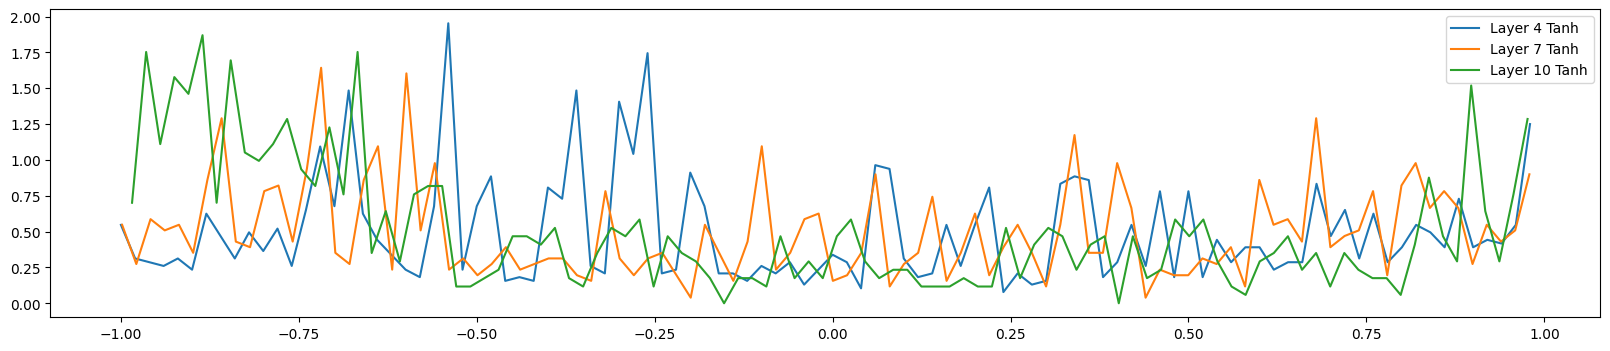

In [246]:
plt.figure(figsize=(20, 4))
legends = []
for i, l in enumerate(model.layers):
    if isinstance(l, Tanh):
        t = l.out
        mean, std = t.mean().item(), t.std().item()
        saturation = ((t.abs() > .97).float().mean() * 100).item()
        print(f"Layer {i} outs: mean={mean:+f}, std={std:e}, saturation={saturation:.2f}%")
        ty, tx = torch.histogram(t, density=True)
        plt.plot(tx[:-1].detach(), ty.detach())
        legends.append(f"Layer {i} {l.__class__.__name__}")
plt.legend(legends);

In [48]:
for layer in model.layers:
    print(layer.out.shape)

torch.Size([32, 8, 10])


AttributeError: 'Conv1D' object has no attribute 'out'